In [1]:
import warnings
warnings.simplefilter("ignore")

import re
import numpy as np 
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

import gensim  # https://pypi.org/project/gensim/
import nltk #https://www.nltk.org/
from nltk.sentiment import SentimentIntensityAnalyzer #https://www.nltk.org/api/nltk.sentiment.html
from textblob import TextBlob #https://textblob.readthedocs.io/en/dev/
from wordcloud import WordCloud, STOPWORDS #https://pypi.org/project/wordcloud/

from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer

import tensorflow as tf
import plotly.express as px
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
from keras.preprocessing.text import Tokenizer
#for confusion matrix
import seaborn
from sklearn.metrics import confusion_matrix
import keras

In [2]:
labled_data_link_1 = "https://www.kaggle.com/datasets/trinhngocphap/covid19-vaccine-tweets-sentiment-10k" # label source unknown(0 = Negative, 1 = Neutral , 2 = Positive) # not so sure about these sentiments
labled_data_link_2 = "https://www.kaggle.com/datasets/datasciencetool/covid19-vaccine-tweets-with-sentiment-annotation" # manually labeled (Negative = 1, neutral = 2, positive = 3)

In [3]:
!pip install opendatasets

import opendatasets as od
import pandas as pd
  
# kaggle name: nadaabbas
# kaggle key: 17ba9cecf27b2758154583bc6c69bcde

od.download(labled_data_link_1)
od.download(labled_data_link_2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nadaabbas
Your Kaggle Key: ··········


100%|██████████| 678k/678k [00:00<00:00, 122MB/s]


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 

nadaabbas
Your Kaggle Key: ··········


100%|██████████| 568k/568k [00:00<00:00, 99.7MB/s]

In [4]:
labled_data_path_1_train = "/content/covid19-vaccine-tweets-sentiment-10k/train_vaccine_tweet.csv"
labled_data_path_1_test = "/content/covid19-vaccine-tweets-sentiment-10k/test_vaccine_tweet.csv"
labled_data_path_2 = "/content/covid19-vaccine-tweets-with-sentiment-annotation/covid-19_vaccine_tweets_with_sentiment.csv"

In [5]:
df_labled_1_train = pd.read_csv(labled_data_path_1_train)
df_labled_1_test = pd.read_csv(labled_data_path_1_test)
df_labled_2 = pd.read_csv(labled_data_path_2, encoding='latin')

## Data Visualization

In [6]:
def basic_eda(df, row_limit=5, list_elements_limit=10):
    ### rows and columns
    print('Info : There are {} columns in the dataset'.format(df.shape[1]))
    print('Info : There are {} rows in the dataset'.format(df.shape[0]))
    
    print("==================================================")
    
    ## data types
    print("\nData type information of different columns")
    dtypes_df = pd.DataFrame(df.dtypes).reset_index().rename(columns={0:'dtype', 'index':'column_name'})
    cat_df = dtypes_df[dtypes_df['dtype']=='object']
    num_df = dtypes_df[dtypes_df['dtype']!='object']
    print('Info : There are {} categorical columns'.format(len(cat_df)))
    print('Info : There are {} numerical columns'.format(len(dtypes_df)-len(cat_df)))
    
    if list_elements_limit >= len(cat_df):
        print("Categorical columns : ", list(cat_df['column_name']))
    else:
        print("Categorical columns : ", list(cat_df['column_name'])[:list_elements_limit])
        
    if list_elements_limit >= len(num_df):
        print("Numerical columns : ", list(num_df['column_name']))
    else:
        print("Numerical columns : ", list(num_df['column_name'])[:list_elements_limit])
    
    #dtypes_df['dtype'].value_counts().plot.bar()
    display(dtypes_df.head(row_limit))
    
    print("==================================================")
    print("\nDescription of numerical variables")
    
    #### Describibg numerical columns
    desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_num.head(row_limit))
    
    print("==================================================")
    print("\nDescription of categorical variables")
    
    desc_df_cat = df[list(cat_df['column_name'])].describe().T.reset_index().rename(columns={'index':'column_name'})
    display(desc_df_cat.head(row_limit))
    
    return

dataset 1 - train

In [7]:
df_labled_1_train.head(10)

,text,sentiment
0,@latingle Too bad they didn't order #Moderna o...,0.0
1,Yes @DollyParton ❤️❤️❤️❤️🥰🥰🥰. AND THANK YOU! #...,2.0
2,I wish anyone taking the mRNA vaccines good lu...,2.0
3,@BBCWorld New crime against humanity :Israeli ...,0.0
4,@BDUTT #Covaxin airlifted?!? ?,1.0
5,UPDATE | Brazil grateful to Russia for allowin...,1.0
6,Deputy PM #Golikova: 5 mln Russians have recei...,1.0
7,Systemic #Reactions Reported within 7 Days aft...,1.0
8,@Jessicam6946 I can't wait to get my second an...,2.0
9,? ? ?? 5 more countries suspend use of #Vac...,0.0


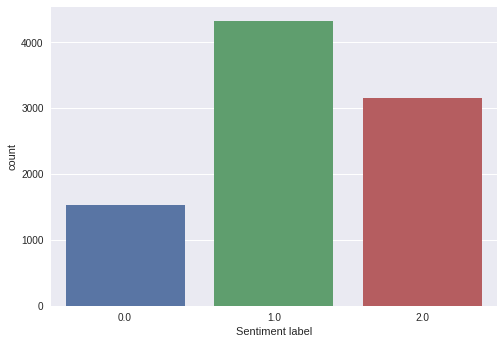

In [8]:
sns.countplot(df_labled_1_train.sentiment)
plt.xlabel('Sentiment label');

In [9]:
df_labled_1_train["sentiment"] = df_labled_1_train["sentiment"].replace({0:-1})
df_labled_1_train["sentiment"] = df_labled_1_train["sentiment"].replace({1:0})
df_labled_1_train["sentiment"] = df_labled_1_train["sentiment"].replace({2:1})

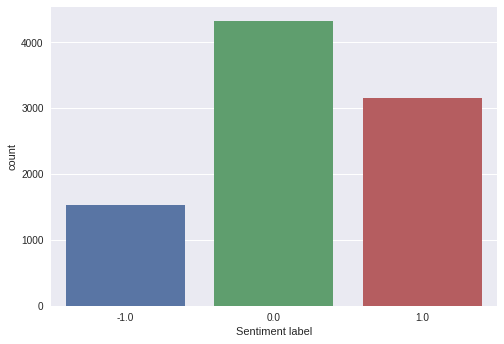

In [10]:
sns.countplot(df_labled_1_train.sentiment)
plt.xlabel('Sentiment label');

In [11]:
basic_eda(df_labled_1_train)

Info : There are 2 columns in the dataset
Info : There are 9000 rows in the dataset

Data type information of different columns
Info : There are 1 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['text']
Numerical columns :  ['sentiment']


,column_name,dtype
0,text,object
1,sentiment,float64



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,sentiment,9000.0,0.18,0.698322,-1.0,0.0,0.0,1.0,1.0



Description of categorical variables


,column_name,count,unique,top,freq
0,text,9000,8980,@BharatBiotech congrats nation TRUST you !!!!!...,2


dataset 1 - test

In [12]:
df_labled_1_test.head(10)

,text,sentiment
0,"#PfizerBioNTech #Tozinameran has 54,828 report...",0.0
1,Mom is doing panic buying whereas Dad panic se...,0.0
2,"Today is my birthday. For my gift my sons, mot...",1.0
3,#OMI Hospital Karachi is charging Rs 15000/-fo...,1.0
4,"Our beloved PM, Shri.Narendra Modi takes his 1...",2.0
5,Super happy to get the #Moderna vaccine 💉 no s...,2.0
6,#Covaxin’s Phase 3 trials results likely next ...,1.0
7,"[05:00:27] 400101, 26-06-2021, 19 dose2 at Ter...",1.0
8,We call on USG to act with speed to trf vaccin...,1.0
9,@BonnieTowner Full vaccinated with #Moderna Fi...,0.0


In [13]:
df_labled_1_test["sentiment"] = df_labled_1_test["sentiment"].replace({0:-1})
df_labled_1_test["sentiment"] = df_labled_1_test["sentiment"].replace({1:0})
df_labled_1_test["sentiment"] = df_labled_1_test["sentiment"].replace({2:1})

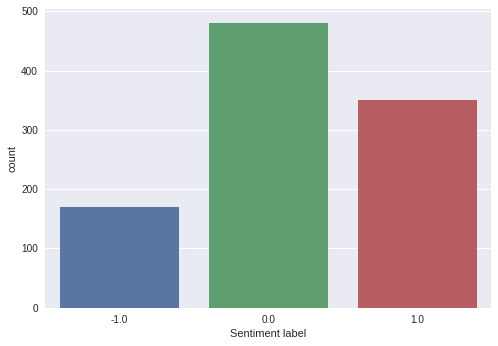

In [14]:
sns.countplot(df_labled_1_test.sentiment)
plt.xlabel('Sentiment label');

In [15]:
basic_eda(df_labled_1_test)

Info : There are 2 columns in the dataset
Info : There are 1000 rows in the dataset

Data type information of different columns
Info : There are 1 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['text']
Numerical columns :  ['sentiment']


,column_name,dtype
0,text,object
1,sentiment,float64



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,sentiment,1000.0,0.18,0.698633,-1.0,0.0,0.0,1.0,1.0



Description of categorical variables


,column_name,count,unique,top,freq
0,text,1000,999,Got my first #COVID19 #vaccination today!!! Gr...,2


dataset 2

In [16]:
df_labled_2.head(10)

,tweet_id,label,tweet_text
0,1.360342e+18,1,"4,000 a day dying from the so called Covid-19 ..."
1,1.382896e+18,2,Pranam message for today manifested in Dhyan b...
2,1.375673e+18,2,Hyderabad-based ?@BharatBiotech? has sought fu...
3,1.381311e+18,1,"Confirmation that Chinese #vaccines ""dont hav..."
4,1.362166e+18,3,"Lab studies suggest #Pfizer, #Moderna vaccines..."
5,1.351285e+18,1,Still want to take the #jab?\n#PfizerBioNTech\...
6,1.377333e+18,2,"This time, Aerolíneas flight AR1068 goes to Mo..."
7,1.363344e+18,3,#Covaxin effective against mutant virus strain...
8,1.372580e+18,3,Safe and effective. #OxfordAstraZeneca
9,1.367507e+18,2,The day after the #Moderna #COVID19Vaccine... ...


In [17]:
df_labled_2["text"] = df_labled_2["tweet_text"]
df_labled_2["sentiment"] = df_labled_2["label"]
df_labled_2.drop("tweet_text", axis=1, inplace=True)
df_labled_2.drop("label", axis=1, inplace=True)
df_labled_2.drop("tweet_id", axis=1, inplace=True)
df_labled_2["sentiment"] = df_labled_2["sentiment"].replace({1:-1})
df_labled_2["sentiment"] = df_labled_2["sentiment"].replace({2:0})
df_labled_2["sentiment"] = df_labled_2["sentiment"].replace({3:1})

In [18]:
df_labled_2.head()

,text,sentiment
0,"4,000 a day dying from the so called Covid-19 ...",-1
1,Pranam message for today manifested in Dhyan b...,0
2,Hyderabad-based ?@BharatBiotech? has sought fu...,0
3,"Confirmation that Chinese #vaccines ""dont hav...",-1
4,"Lab studies suggest #Pfizer, #Moderna vaccines...",1


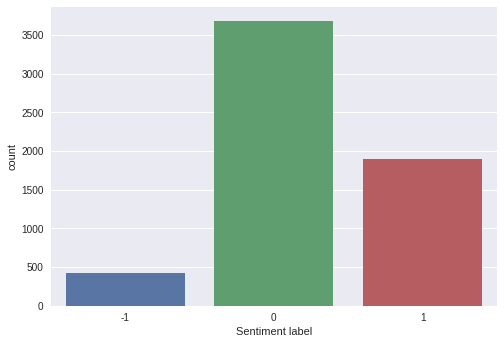

In [19]:
sns.countplot(df_labled_2["sentiment"])
plt.xlabel('Sentiment label');

In [20]:
basic_eda(df_labled_2)

Info : There are 2 columns in the dataset
Info : There are 6000 rows in the dataset

Data type information of different columns
Info : There are 1 categorical columns
Info : There are 1 numerical columns
Categorical columns :  ['text']
Numerical columns :  ['sentiment']


,column_name,dtype
0,text,object
1,sentiment,int64



Description of numerical variables


,column_name,count,mean,std,min,25%,50%,75%,max
0,sentiment,6000.0,0.246667,0.570856,-1.0,0.0,0.0,1.0,1.0



Description of categorical variables


,column_name,count,unique,top,freq
0,text,6000,5991,"Selling: #NitrileGloves, #1860 #FaceMasks, #Va...",4


## ro-BERT-a Model Prediction:

In [21]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.3 MB/s eta 0:00:00


In [22]:
from transformers import pipeline
sentiment_analysis = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment-latest')

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
def getBertPredictions(tweets_df):
  transformer_sentiments = tweets_df.text.apply(sentiment_analysis)

  labels = []
  scores = []
  for sentiment in transformer_sentiments:
      #print(f"label: {sentiment[0]['label']}, with score: {round(sentiment[0]['score'], 4)}")
      labels.append(sentiment[0]['label'])
      scores.append(round(sentiment[0]['score'], 4))

  tweets_df['tf-sentiment'] = labels
  tweets_df['tf-score'] = scores
  tweets_df[['text', 'tf-sentiment', 'tf-score']].head(100)
  
  return tweets_df

Predict for dataset 1:

In [24]:
df_labled_1_train = getBertPredictions(df_labled_2)
df_labled_1_train.head()

,text,sentiment,tf-sentiment,tf-score
0,"4,000 a day dying from the so called Covid-19 ...",-1,negative,0.7656
1,Pranam message for today manifested in Dhyan b...,0,neutral,0.5806
2,Hyderabad-based ?@BharatBiotech? has sought fu...,0,neutral,0.8561
3,"Confirmation that Chinese #vaccines ""dont hav...",-1,negative,0.7358
4,"Lab studies suggest #Pfizer, #Moderna vaccines...",1,neutral,0.6976


In [25]:
df_labled_1_test = getBertPredictions(df_labled_2)
df_labled_1_test.head()

,text,sentiment,tf-sentiment,tf-score
0,"4,000 a day dying from the so called Covid-19 ...",-1,negative,0.7656
1,Pranam message for today manifested in Dhyan b...,0,neutral,0.5806
2,Hyderabad-based ?@BharatBiotech? has sought fu...,0,neutral,0.8561
3,"Confirmation that Chinese #vaccines ""dont hav...",-1,negative,0.7358
4,"Lab studies suggest #Pfizer, #Moderna vaccines...",1,neutral,0.6976


In [26]:
df_labled_2 = getBertPredictions(df_labled_2)
df_labled_2.head()

,text,sentiment,tf-sentiment,tf-score
0,"4,000 a day dying from the so called Covid-19 ...",-1,negative,0.7656
1,Pranam message for today manifested in Dhyan b...,0,neutral,0.5806
2,Hyderabad-based ?@BharatBiotech? has sought fu...,0,neutral,0.8561
3,"Confirmation that Chinese #vaccines ""dont hav...",-1,negative,0.7358
4,"Lab studies suggest #Pfizer, #Moderna vaccines...",1,neutral,0.6976


In [2]:
import pandas as pd

In [3]:
df_labled_1_train = pd.read_csv("df_labled_1_train.csv")
df_labled_1_test = pd.read_csv("df_labled_1_test.csv")
df_labled_2 = pd.read_csv("df_labled_2.csv")
DistilBERT_results = pd.read_csv("comparison_1_results_h.csv")

In [4]:
def convert_sentiment_to_numb(df):
  df["tf-sentiment"] = df["tf-sentiment"].replace({"negative":-1})
  df["tf-sentiment"] = df["tf-sentiment"].replace({"neutral":0})
  df["tf-sentiment"] = df["tf-sentiment"].replace({"positive":1})
  return df

In [5]:
df_labled_1_train = convert_sentiment_to_numb(df_labled_1_train)
df_labled_1_train.head()

,Unnamed: 0,text,sentiment,tf-sentiment,tf-score
0,0,"4,000 a day dying from the so called Covid-19 ...",-1,-1,0.7656
1,1,Pranam message for today manifested in Dhyan b...,0,0,0.5806
2,2,Hyderabad-based ?@BharatBiotech? has sought fu...,0,0,0.8561
3,3,"Confirmation that Chinese #vaccines ""dont hav...",-1,-1,0.7358
4,4,"Lab studies suggest #Pfizer, #Moderna vaccines...",1,0,0.6976


In [6]:
df_labled_1_test = convert_sentiment_to_numb(df_labled_1_test)
df_labled_1_test.head()

,Unnamed: 0,text,sentiment,tf-sentiment,tf-score
0,0,"4,000 a day dying from the so called Covid-19 ...",-1,-1,0.7656
1,1,Pranam message for today manifested in Dhyan b...,0,0,0.5806
2,2,Hyderabad-based ?@BharatBiotech? has sought fu...,0,0,0.8561
3,3,"Confirmation that Chinese #vaccines ""dont hav...",-1,-1,0.7358
4,4,"Lab studies suggest #Pfizer, #Moderna vaccines...",1,0,0.6976


In [7]:
df_labled_2 = convert_sentiment_to_numb(df_labled_2)
df_labled_2.head()

,Unnamed: 0,text,sentiment,tf-sentiment,tf-score
0,0,"4,000 a day dying from the so called Covid-19 ...",-1,-1,0.7656
1,1,Pranam message for today manifested in Dhyan b...,0,0,0.5806
2,2,Hyderabad-based ?@BharatBiotech? has sought fu...,0,0,0.8561
3,3,"Confirmation that Chinese #vaccines ""dont hav...",-1,-1,0.7358
4,4,"Lab studies suggest #Pfizer, #Moderna vaccines...",1,0,0.6976


In [8]:
results = DistilBERT_results[["datasets", "texts_count","Negative_count","Neutral_count", "Positive_count", "TP_Neg_Vader","TP_Neut_Vader", "TP_Pos_Vader", "vader_acc" ]]
results

,datasets,texts_count,Negative_count,Neutral_count,Positive_count,TP_Neg_Vader,TP_Neut_Vader,TP_Pos_Vader,vader_acc
0,dataset 1 - train,9000,1530,4320,3150,84.97%,52.41%,72.41%,0.649444
1,dataset 1 - test,1000,170,480,350,88.24%,52.50%,74.57%,0.663000
2,dataset 2,6000,420,3680,1900,53.33%,38.61%,60%,0.464833


In [9]:
def calculate_accuracy(df):
   correct = (df["tf-sentiment"] == df["sentiment"])
   accuracy = correct.sum() / correct.size 
   return accuracy

In [10]:
bert_acc_ds_1_train = calculate_accuracy(df_labled_1_train)
bert_acc_ds_1_test = calculate_accuracy(df_labled_1_test)
bert_acc_ds_2 = calculate_accuracy(df_labled_2)

results["ro-Bert-a_acc"] = [bert_acc_ds_1_train, bert_acc_ds_1_test, bert_acc_ds_2]
results

<ipython-input-10-75981177ad2a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["ro-Bert-a_acc"] = [bert_acc_ds_1_train, bert_acc_ds_1_test, bert_acc_ds_2]


,datasets,texts_count,Negative_count,Neutral_count,Positive_count,TP_Neg_Vader,TP_Neut_Vader,TP_Pos_Vader,vader_acc,ro-Bert-a_acc
0,dataset 1 - train,9000,1530,4320,3150,84.97%,52.41%,72.41%,0.649444,0.629333
1,dataset 1 - test,1000,170,480,350,88.24%,52.50%,74.57%,0.663000,0.629333
2,dataset 2,6000,420,3680,1900,53.33%,38.61%,60%,0.464833,0.629333


In [11]:
def get_TP_perc_bert(df, label):
  count_res = (df["tf-sentiment"]==label)*(df["sentiment"]==label)
  TP_count = (count_res[count_res==True]).count()

  return TP_count*100/df["sentiment"].value_counts()[label]

In [12]:
TP_Neg_1 = get_TP_perc_bert(df_labled_1_train,-1)
TP_Neut_1 = get_TP_perc_bert(df_labled_1_train,0)
TP_pos_1 = get_TP_perc_bert(df_labled_1_train,1)

TP_Neg_2 = get_TP_perc_bert(df_labled_1_test,-1)
TP_Neut_2 = get_TP_perc_bert(df_labled_1_test,0)
TP_pos_2 = get_TP_perc_bert(df_labled_1_test,1)

TP_Neg_3 = get_TP_perc_bert(df_labled_2,-1)
TP_Neut_3 = get_TP_perc_bert(df_labled_2,0)
TP_pos_3 = get_TP_perc_bert(df_labled_2,1)

TP_Neg_Bert_wLR = [f"{round(TP_Neg_1,2)}%", f"{round(TP_Neg_2,2)}%", f"{round(TP_Neg_3,2)}%"]
TP_Neut_Bert_wLR = [f"{round(TP_Neut_1,2)}%", f"{round(TP_Neut_2,2)}%", f"{round(TP_Neut_3,2)}%"]
TP_Pos_Bert_wLR = [f"{round(TP_pos_1,2)}%", f"{round(TP_pos_2,2)}%", f"{round(TP_pos_3)}%"]

results["TP_Neg_Bert"] = TP_Neg_Bert_wLR
results["TP_Neut_Bert"] = TP_Neut_Bert_wLR
results["TP_Pos_Bert"] = TP_Pos_Bert_wLR
results

<ipython-input-12-67f8a00a7e6b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["TP_Neg_Bert"] = TP_Neg_Bert_wLR
<ipython-input-12-67f8a00a7e6b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["TP_Neut_Bert"] = TP_Neut_Bert_wLR
<ipython-input-12-67f8a00a7e6b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,datasets,texts_count,Negative_count,Neutral_count,Positive_count,TP_Neg_Vader,TP_Neut_Vader,TP_Pos_Vader,vader_acc,ro-Bert-a_acc,TP_Neg_Bert,TP_Neut_Bert,TP_Pos_Bert
0,dataset 1 - train,9000,1530,4320,3150,84.97%,52.41%,72.41%,0.649444,0.629333,69.76%,65.65%,56.16%
1,dataset 1 - test,1000,170,480,350,88.24%,52.50%,74.57%,0.663000,0.629333,69.76%,65.65%,56.16%
2,dataset 2,6000,420,3680,1900,53.33%,38.61%,60%,0.464833,0.629333,69.76%,65.65%,56%


In [13]:
results.to_csv("ro-Bert-a_vs_VADER_results.csv",  header=True, index=False)

In [14]:
df_labled_1_train['TF-diff'] =  df_labled_1_train['sentiment'].ne(df_labled_1_train['tf-sentiment'])
TFtotal_count1 = df_labled_1_train['TF-diff'].sum()

df_labled_1_test['TF-diff'] =  df_labled_1_test['sentiment'].ne(df_labled_1_test['tf-sentiment'])
TFtotal_count2 = df_labled_1_test['TF-diff'].sum()

df_labled_2['TF-diff'] =  df_labled_2['sentiment'].ne(df_labled_2['tf-sentiment'])
TFtotal_count3 = df_labled_2['TF-diff'].sum()

In [15]:
print(TFtotal_count1)
print(TFtotal_count2)
print(TFtotal_count3)

2224
2224
2224


In [16]:
def accuracy(y_true, y_pred):
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            correct += 1
    return correct / len(y_true)

In [18]:
accuracy(df_labled_1_train['sentiment'],df_labled_1_train['tf-sentiment'])

0.6293333333333333

In [19]:
accuracy(df_labled_1_test['sentiment'],df_labled_1_test['tf-sentiment'])

0.6293333333333333

In [20]:
accuracy(df_labled_2['sentiment'],df_labled_2['tf-sentiment'])

0.6293333333333333